## Machine learning modeling - best model visualization

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from mlxtend.plotting import plot_decision_regions
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.options.display.max_rows = 999

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil
import jenkspy
import statsmodels
import statsmodels.api as sm

# ml modules
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.utils import resample

In [2]:
# read in 990 data that has been
# subsetted and cleaned in 990_cont_comp_EDA notebook
df = pd.read_csv('data/990_model_data_3.csv')

In [3]:
df.shape

(26881, 28)

In [20]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
0,True,False,False,False,12_,15549792,11,11,37,0.0,0,0.0,0.0,39372255.0,26541056.0,12831199.0,0,39367859,26785093,12582766,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07
1,True,False,False,False,14_,9472036,9,8,81,8.0,52565,-75519.0,1000243.0,173898488.0,88052685.0,16354368.0,1262299,188534687,90509772,17619471,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07
2,True,False,False,False,5_,8503978,21,19,53,200.0,16110,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972,3640881,852359,2788522,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07
3,True,False,False,False,3_,57422298,8,7,442,15.0,0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630,56726534,12198910,44527624,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07
4,True,False,False,False,7_,5974176,12,12,139,50.0,2437,0.0,344252.0,9803605.0,3104088.0,6699517.0,745724,10535130,3089889,7445241,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07


In [4]:
# create features for classification
# while removing those I created in designing
# my target variable
X = pd.get_dummies(df).drop(['TARGET_FEATURE',
            'CON_CT_DIV_EMP_VOL_CT_flag', 
             'CON_EXP_DIV_TOT_EXP_flag',
            'CON_CT_DIV_EMP_VOL_CT',
            'CON_EXP_DIV_TOT_EXP',
            'volunteer_tot_ct',
            'employee_tot_ct',
            'contractor_100k_ct'], axis=1)

# create target for classification
y = df.TARGET_FEATURE

In [5]:
X.shape

(26881, 38)

In [88]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
X.shape

(26881, 38)

<a id="gradient_boost_classifier"></a>

### Gradient Boost Classifier

In [49]:
# fit model based on grid search parameters
params = {'n_estimators': 950,
          'max_depth': 2,
          'subsample': .8,
          'learning_rate': .1,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=950,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [101]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.003859747023809524
Percent Type II errors: 0.08351934523809523

Test set accuracy:
Percent Type I errors: 0.013576343686070299
Percent Type II errors: 0.08573554026408778


In [51]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19061,83
Actual: Yes,1796,564


In [52]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4755,73
Actual: Yes,461,88


Gradient Boost Classifier did a much better job of predicting Yes

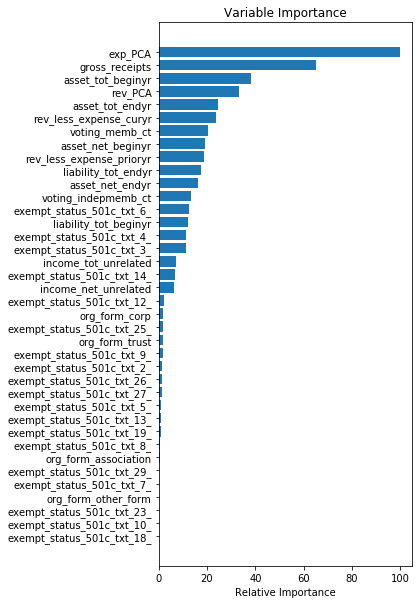

In [29]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (clf.feature_importances_ / clf.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

### Visualizations examining classification results

In [103]:
# combine test set predictions with df
# to create visualizations for Type I & Type II errors
df_with_pred = pd.concat([df.iloc[X_test.index].reset_index(), pd.Series(predict_test)], axis=1)

In [169]:
df_with_pred.head()

,index,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA,0
0,18813,True,False,False,False,4_,7.942360e+05,8,8,6,0.0,0.0,0.0,54831.0,9.520641e+06,4.044151e+06,5476490.0,21611.0,8.810439e+06,3.312338e+06,5498101.0,1,0.166667,0.264980,True,False,False,-1.215951e+08,-1.036099e+08,False
1,2161,True,False,False,False,3_,1.198234e+09,32,27,5285,0.0,5503201.2,0.0,85464866.4,2.007782e+09,1.082905e+09,787226494.0,-218377154.0,2.072073e+09,1.169530e+09,670919531.0,167,0.054683,4.087313,False,True,False,1.871040e+09,1.549296e+09,False
2,5453,True,False,False,False,3_,5.658511e+08,18,16,2398,17.0,2711626.0,268200.0,19599023.0,1.306178e+09,1.082905e+09,155893581.0,21424590.0,1.600675e+09,1.146370e+09,454305205.0,134,0.055487,1.371334,False,True,False,8.282147e+08,6.544436e+08,False
3,19697,True,False,False,False,3_,4.487151e+06,12,12,27,695.0,0.0,0.0,-207311.0,3.541433e+06,1.565050e+05,3384928.0,-158900.0,3.557726e+06,3.316980e+05,3226028.0,2,0.002770,0.160454,False,False,False,-1.201244e+08,-1.006969e+08,False
4,20822,True,False,False,False,3_,2.327829e+07,5,5,262,26.0,31384.0,28985.0,-3080310.0,1.364939e+07,2.544957e+07,-11800186.0,-1802817.0,1.295637e+07,2.797893e+07,-15022559.0,5,0.017361,0.089615,False,False,False,-7.877878e+07,-6.356010e+07,False


In [110]:
# find false negatives (Type II errors)
# verify count matches that of above
df_with_pred[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == False)].shape

(461, 30)

In [111]:
# find false positives (Type I errors)
# verify count matches that of above
df_with_pred[(df_with_pred.TARGET_FEATURE == False) &
            (df_with_pred.loc[:,0] == True)].shape

(73, 30)

### Contractor Count & Employee Count Visualization

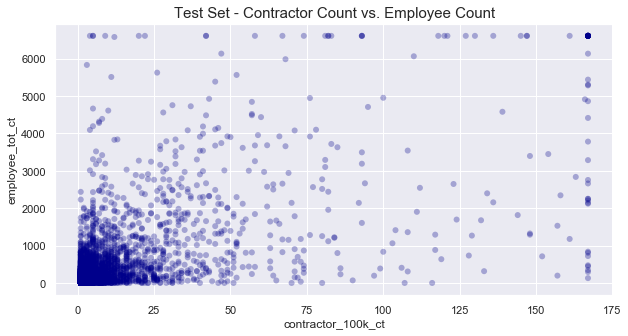

In [173]:
fig = plt.figure(figsize=(10, 5))

sns.scatterplot(df_with_pred.contractor_100k_ct,
           df_with_pred.employee_tot_ct,
           color='darkblue',
           alpha=.3,
           edgecolor="none")
plt.title('Test Set - Contractor Count vs. Employee Count', fontsize=15)
# plt.savefig('visualizations/test_set_cont_count_emp_count.png');

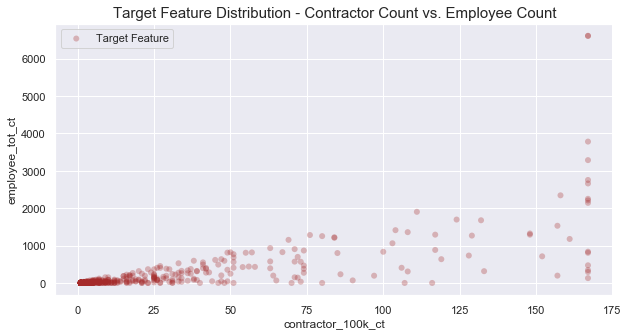

In [174]:
fig = plt.figure(figsize=(10, 5))

# sns.scatterplot(df_with_pred.contractor_100k_ct,
#            df_with_pred.employee_tot_ct,
#            color='blue',
#            alpha=.3,
#            edgecolor="none")

sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True), 'contractor_100k_ct'],
               df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True), 'employee_tot_ct'],
                color='brown',
                alpha=.3,
                edgecolor='none',
                label="Target Feature")
plt.title('Target Feature Distribution - Contractor Count vs. Employee Count', fontsize=15)
# plt.savefig('visualizations/cont_count_emp_count_target_feature.png');

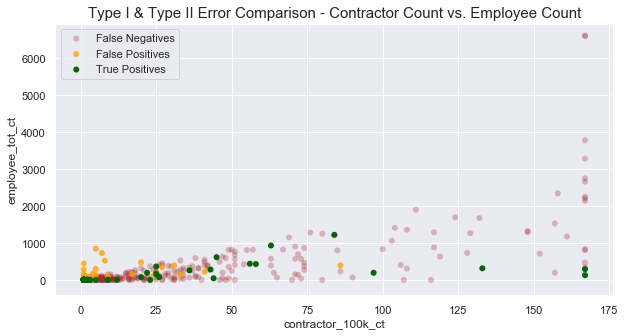

In [214]:
fig = plt.figure(figsize=(10, 5))

# find false negatives (Type II errors)
sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == False), 'contractor_100k_ct'],
               df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == False), 'employee_tot_ct'],
                color='brown',
                alpha=.3,
                edgecolor='none',
                label="False Negatives")

# find false positives (Type I errors)
sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == False) &
            (df_with_pred.loc[:,0] == True), 'contractor_100k_ct'],
               df_with_pred.loc[(df_with_pred.TARGET_FEATURE == False) &
            (df_with_pred.loc[:,0] == True), 'employee_tot_ct'],
                color='orange',
                alpha=.8,
                edgecolor='none',
              label="False Positives")

sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == True), 'contractor_100k_ct'],
               df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == True), 'employee_tot_ct'],
                color='darkgreen',
                alpha=1,
                edgecolor='none',
              label="True Positives")


plt.title('Type I & Type II Error Comparison - Contractor Count vs. Employee Count', fontsize=15)
# plt.savefig('visualizations/cont_count_emp_count_type_I_type_II.png');

### Contractor Count & Expenses Visualization

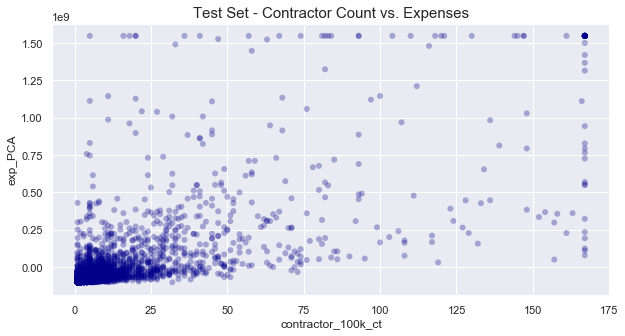

In [176]:
fig = plt.figure(figsize=(10, 5))

sns.scatterplot(df_with_pred.contractor_100k_ct,
           df_with_pred.exp_PCA,
           color='darkblue',
           alpha=.3,
           edgecolor="none")
plt.title('Test Set - Contractor Count vs. Expenses', fontsize=15)
# plt.savefig('visualizations/test_set_cont_count_expenses.png');

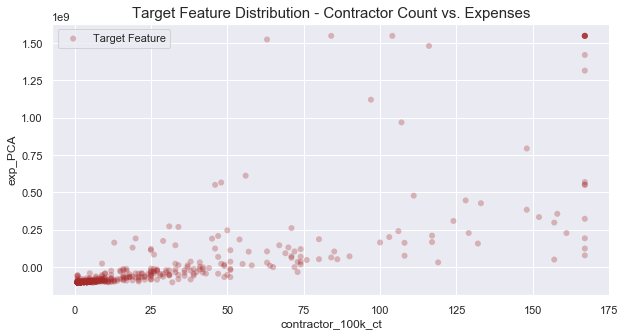

In [178]:
fig = plt.figure(figsize=(10, 5))

sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True), 'contractor_100k_ct'],
               df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True), 'exp_PCA'],
                color='brown',
                alpha=.3,
                edgecolor='none',
                label="Target Feature")

plt.title('Target Feature Distribution - Contractor Count vs. Expenses', fontsize=15)
# plt.savefig('visualizations/cont_count_expenses_target_feature.png');

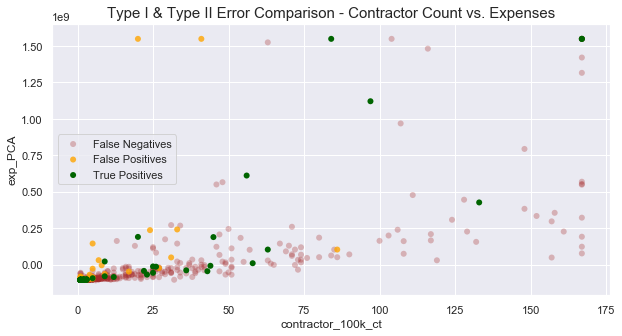

In [213]:
fig = plt.figure(figsize=(10, 5))

# find false negatives (Type II errors)
sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == False), 'contractor_100k_ct'],
               df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == False), 'exp_PCA'],
                color='brown',
                alpha=.3,
                edgecolor='none',
                label="False Negatives")

# find false positives (Type I errors)
sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == False) &
            (df_with_pred.loc[:,0] == True), 'contractor_100k_ct'],
               df_with_pred.loc[(df_with_pred.TARGET_FEATURE == False) &
            (df_with_pred.loc[:,0] == True), 'exp_PCA'],
                color='orange',
                alpha=.8,
                edgecolor='none',
              label="False Positives")

sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == True), 'contractor_100k_ct'],
               df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == True), 'exp_PCA'],
                color='darkgreen',
                alpha=1,
                edgecolor='none',
              label="True Positives")

plt.title('Type I & Type II Error Comparison - Contractor Count vs. Expenses', fontsize=15)
# plt.savefig('visualizations/cont_count_expenses_type_I_type_II.png');

### Gross Receipts

Text(0.5, 1.0, 'Type I & Type II Error Comparison - Contractor Count vs. Expenses')

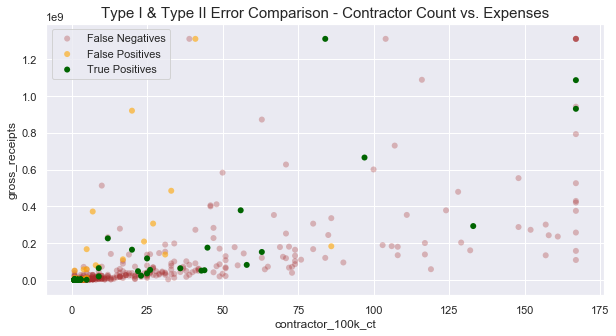

In [203]:
fig = plt.figure(figsize=(10, 5))

# find false negatives (Type II errors)
sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == False), 'contractor_100k_ct'],
               df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == False), 'gross_receipts'],
                color='brown',
                alpha=.3,
                edgecolor='none',
                label="False Negatives")

# find false positives (Type I errors)
sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == False) &
            (df_with_pred.loc[:,0] == True), 'contractor_100k_ct'],
               df_with_pred.loc[(df_with_pred.TARGET_FEATURE == False) &
            (df_with_pred.loc[:,0] == True), 'gross_receipts'],
                color='orange',
                alpha=.6,
                edgecolor='none',
              label="False Positives")

sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == True), 'contractor_100k_ct'],
               df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
            (df_with_pred.loc[:,0] == True), 'gross_receipts'],
                color='darkgreen',
                alpha=1,
                edgecolor='none',
              label="True Positives")

plt.title('Type I & Type II Error Comparison - Contractor Count vs. Expenses', fontsize=15)
# plt.savefig('visualizations/cont_count_expenses_type_I_type_II.png');

### plot_decision_regions

In [71]:
clf.fit(df[['rev_PCA', 'exp_PCA']], y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=950,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

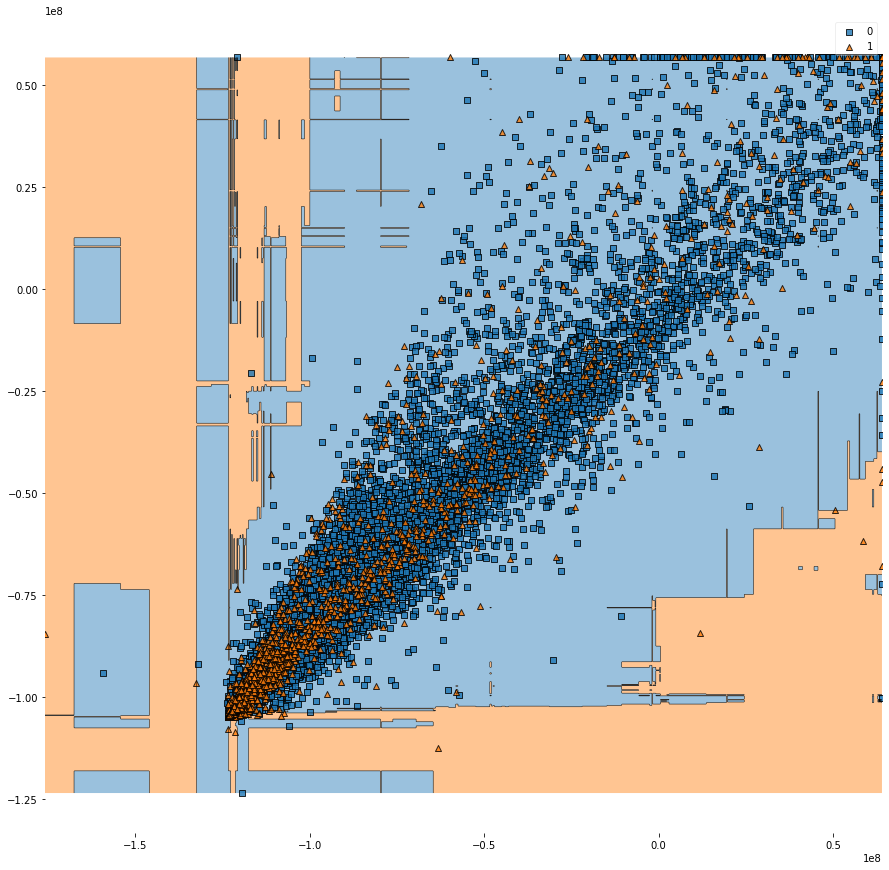

In [73]:
plt.figure(figsize=(15, 15))

plot_decision_regions(np.array(df[['rev_PCA', 'exp_PCA']], dtype = np.float64)
                      ,np.array(y, dtype = np.integer), 
                      clf=clf, legend=2)